In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model
import os
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from itertools import chain

from statistics import mean
cancerData=pd.read_csv('prostate.txt',delimiter='\t')

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
cancerData

,id,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,1,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,2,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,3,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,4,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,5,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T
...,...,...,...,...,...,...,...,...,...,...,...
92,93,2.830268,3.876396,68,-1.386294,1,1.321756,7,60,4.385147,T
93,94,3.821004,3.896909,44,-1.386294,1,2.169054,7,40,4.684443,T
94,95,2.907447,3.396185,52,-1.386294,1,2.463853,7,10,5.143124,F
95,96,2.882564,3.773910,68,1.558145,1,1.558145,7,80,5.477509,T


In [4]:
cancerData=pd.read_csv('prostate.txt',delimiter='\t')

trainCancer=cancerData[cancerData.loc[:,'train']=='T']

testCancer=cancerData[cancerData.loc[:,'train']=='F']

x_train=trainCancer.drop(columns=['id','lpsa','train'])
y_train=trainCancer.loc[:,'lpsa']

x_test= testCancer.drop(columns=['id','lpsa','train'])
y_test=testCancer.loc[:,'lpsa']





x_train_kfold = x_train
y_train_kfold = y_train



x_test_kfold = x_test
y_test_kfold = y_test


# x_train_scaled,scalar_train = ztransform(x_train,scaler)

# x_test_scaled = scalar_train.transform(x_test)


x_train_scaled=sklearn.preprocessing.scale(x_train, axis=0, with_mean=True, with_std=True, copy=True)

x_test_scaled=sklearn.preprocessing.scale(x_test, axis=0, with_mean=True, with_std=True, copy=True)


x_train_scaled=np.array(x_train_scaled)
y_train=np.array(y_train)
y_train=y_train.reshape(-1,1)




y_test=np.array(y_test)
y_test=y_test.reshape(-1,1)


addBias=np.ones([x_train_scaled.shape[0],1])

x_train_scaled=np.append(addBias,x_train_scaled,axis=1)

addBias=np.ones([x_test_scaled.shape[0],1])
x_test_scaled=np.append(addBias,x_test_scaled,axis=1)



In [5]:
np.shape(x_train_scaled)

(67, 9)

In [6]:
def getPred(x,W):
    return(np.matmul(x,W))
def Loss(y,ypred):
    l=(y-ypred)**2

    return(l.sum())

def MSE(X,Y,W):

    return(0.5*(1/(X.shape[0]))*Loss(Y,getPred(X,W)))

def accuracy(Y,predictions):
    correct = 0
    
    for i in range(len(predictions)):
        if(predictions[i]==Y[i]):
            correct = correct+1
    return correct
    

In [7]:
def GradDesc(X,Y,learnRate,epochs,reg):
    
    mean_squared_error = np.zeros(epochs)
    Weights=np.random.rand(X.shape[1])
    
    Weights=np.array(Weights)
    Weights=Weights.reshape(-1,1)
    m=X.shape[0]
        
    weight_array = np.zeros((epochs,X.shape[1]),dtype=float)
    
    for i in range(epochs):
        
        predictions=getPred(X,Weights)
        
        
        dw = np.zeros(len(Weights))
        # untrained weights 0 updated 
        Weights[0]=Weights[0]-(1/m)*learnRate*(np.matmul(X[:,0].transpose(),predictions-Y))
        
        # actual training starts here
        
        for j in range(1,len(Weights)):
            
            if Weights[j]>0:               
                dw[j] = (1/m)*((((np.matmul(X[:,j].transpose(),predictions-Y)))+reg))
                Weights[j] = Weights[j] - (learnRate*dw[j])
                              
            else:
                dw[j] = (1/m)*((((np.matmul(X[:,j].transpose(),predictions-Y)))-reg))


                Weights[j] = Weights[j] - (learnRate*dw[j])
                
        weight_array[i,:] = Weights.reshape(X.shape[1],)
        mean_squared_error[i] = MSE(X,Y,Weights)
        

    return Weights, mean_squared_error, weight_array

In [8]:
def train_modelkfold(data, label,repeated,folds,regularization_paramter,epochs,learning_rate):
    accuracy_list = np.zeros((repeated,folds),dtype=float) 
    Lasso_MSE_train = np.zeros((repeated,folds),dtype=float)
    Lasso_MSE_train_list = np.zeros((repeated,folds),dtype=object)

    Lasso_MSE_test = np.zeros((repeated,folds),dtype=float)
    
    Lasso_MSE_per_Kfold_average = np.zeros(repeated,dtype=float)
    
    Lasso_MSE_train_mean = 0

    Lasso_MSE_train_mean1 = []
    Lasso_MSE_train_std = 0
    
    weight_array = np.zeros((repeated,folds,np.shape(data)[1]))
    
    Lasso_MSE_train_list_mean = 0

    
    for repeated in range(repeated):
        
        print("========Repeated fold number",str(repeated),"========")
        kfold = KFold(folds, shuffle=True)
        
        for k, (training_indices, testing_indices) in enumerate(kfold.split(data)):
            
            accuracy = 0
            trainX, trainY, testX, testY = data[training_indices], label[training_indices], data[testing_indices], label[testing_indices]
            
            # train using gradient descent on train data
            Wlasso_train,MSE_train,weight_array2=GradDesc(trainX,trainY,learnRate=learning_rate,epochs=epochs,reg=regularization_paramter)
            
            
            # final MSE
            Lasso_MSE_train[repeated,k] = MSE_train[-1]
            
            Lasso_MSE_train_list[repeated,k] = MSE_train
            # testing using test data
            
            MSE_test=MSE(testX,testY,Wlasso_train)
            
            Lasso_MSE_test[repeated,k] = MSE_test
            

            accuracy = 100-(MSE_test)
            
            accuracy_list[repeated,k] = accuracy
            weight_array[repeated,k,:] =  Wlasso_train.reshape(data.shape[1],)
            
    Lasso_MSE_train_mean = np.mean(list(chain.from_iterable(zip(*Lasso_MSE_train))))

    Lasso_MSE_train_std = np.std(list(chain.from_iterable(zip(*Lasso_MSE_train))))
        
    return Lasso_MSE_train, Lasso_MSE_train_list, Lasso_MSE_train_mean,Lasso_MSE_train_std,  Lasso_MSE_test, accuracy_list, weight_array

In [9]:
Lasso_MSE_train, Lasso_MSE_train_list, Lasso_MSE_train_mean,Lasso_MSE_train_std,  Lasso_MSE_test, accuracy_list, weight_array = train_modelkfold(x_train_scaled, y_train,10,10,2.3,70,0.37)

========Repeated fold number 0 ========
========Repeated fold number 1 ========
========Repeated fold number 2 ========
========Repeated fold number 3 ========
========Repeated fold number 4 ========
========Repeated fold number 5 ========
========Repeated fold number 6 ========
========Repeated fold number 7 ========
========Repeated fold number 8 ========
========Repeated fold number 9 ========


In [10]:
Lasso_MSE_train_mean

0.23028817067127386

In [11]:
Lasso_MSE_test = list(chain.from_iterable(zip(*Lasso_MSE_test)))
np.mean(Lasso_MSE_test,axis=0)

0.30120942992480193

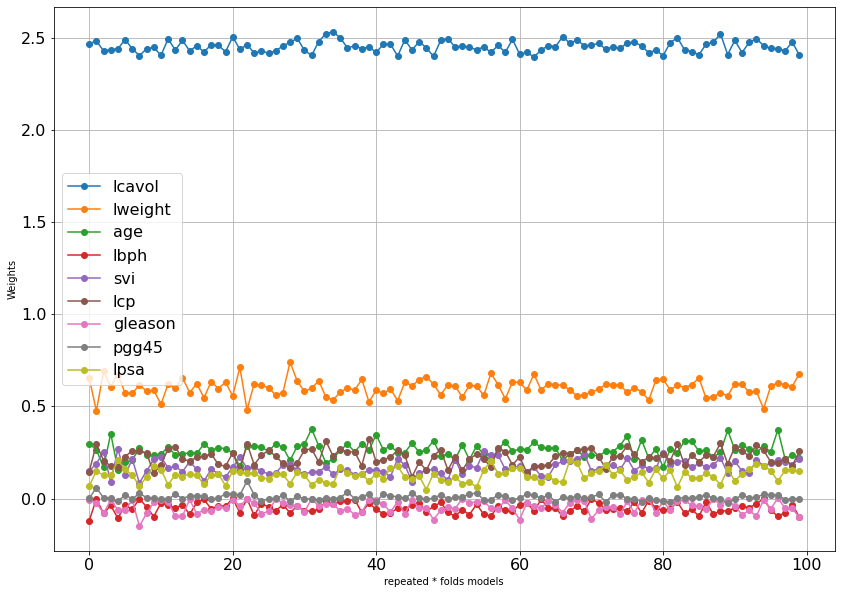

In [12]:
weight_array_list = list(chain.from_iterable(zip(*weight_array)))

weight_list0 = np.zeros(100)
weight_list1 = np.zeros(100)
weight_list2 = np.zeros(100)
weight_list3 = np.zeros(100)
weight_list4 = np.zeros(100)
weight_list5 = np.zeros(100)
weight_list6 = np.zeros(100)
weight_list7 = np.zeros(100)
weight_list8 = np.zeros(100)

for i in range(len(weight_array_list)):
       weight_list0[i] = weight_array_list[i][0]
       weight_list1[i] = weight_array_list[i][1]
       weight_list2[i] = weight_array_list[i][2]
       weight_list3[i] = weight_array_list[i][3]
       weight_list4[i] = weight_array_list[i][4]
       weight_list5[i] = weight_array_list[i][5]
       weight_list6[i] = weight_array_list[i][6]
       weight_list7[i] = weight_array_list[i][7]
       weight_list8[i] = weight_array_list[i][8]
    
legend_list = cancerData.keys()[1:-1]
plt.rcParams["figure.figsize"] = (14,10)
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}
plt.tick_params(labelsize=16)
plt.grid()
plt.rc('font', **font)
plt.plot(weight_list0,label = legend_list[0],marker='o')
plt.plot(weight_list1,label = legend_list[1],marker='o')
plt.plot(weight_list2,label = legend_list[2],marker='o')
plt.plot(weight_list3,label = legend_list[3],marker='o')
plt.plot(weight_list4,label = legend_list[4],marker='o')
plt.plot(weight_list5,label = legend_list[5],marker='o')
plt.plot(weight_list6,label = legend_list[6],marker='o')
plt.plot(weight_list7,label = legend_list[7],marker='o')
plt.plot(weight_list8,label = legend_list[8],marker='o')
plt.legend()

plt.xlabel('repeated * folds models')
plt.ylabel('Weights')

plt.savefig('MSE_kfold_weight_lasso.png')
plt.show()

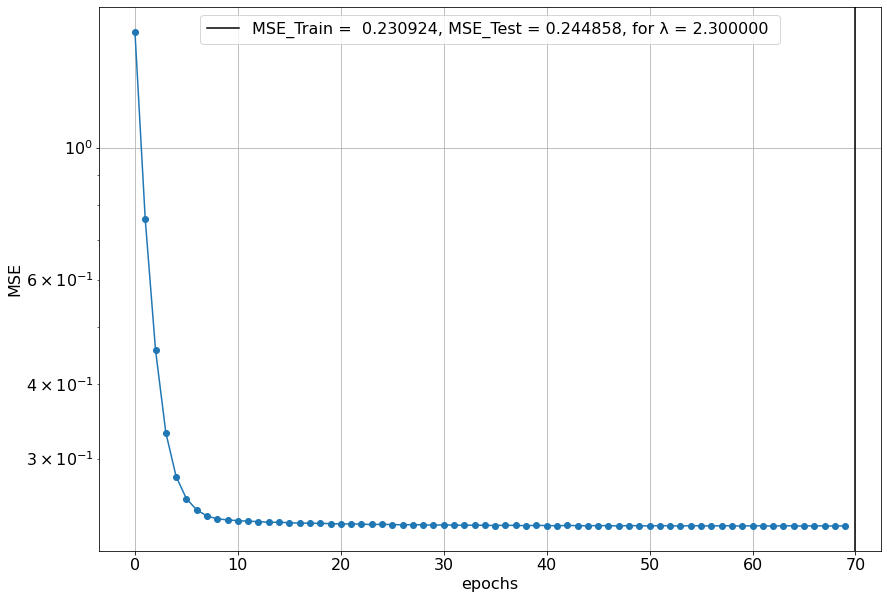

In [13]:
Wlasso, mean_squared_error,weight_array = GradDesc(x_train_scaled,y_train,0.37,70,2.3)
MSE_test_single = MSE(x_test_scaled,y_test,Wlasso)

legend_list = cancerData.keys()[1:-1]
plt.rcParams["figure.figsize"] = (14,10)
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}
plt.tick_params(labelsize=16)
plt.grid()
plt.rc('font', **font)
plt.semilogy(mean_squared_error,marker='o')
plt.axvline(x=70,label= 'MSE_Train =  %f, MSE_Test = %f, for λ = %f '%(min(mean_squared_error),MSE_test_single,2.3),color='k')    
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend()
plt.savefig('lassor_MSE_singel_log.png')
plt.show()


In [14]:
mean_squared_error[-1]

0.2312016683038398

In [15]:
MSE_test_single

0.2448583252446093

In [16]:
Wlasso

array([[ 2.45234509e+00],
       [ 6.09813630e-01],
       [ 2.64307447e-01],
       [-6.11849694e-02],
       [ 1.73904677e-01],
       [ 2.30102680e-01],
       [-7.09022706e-02],
       [ 4.65064032e-04],
       [ 1.38040041e-01]])

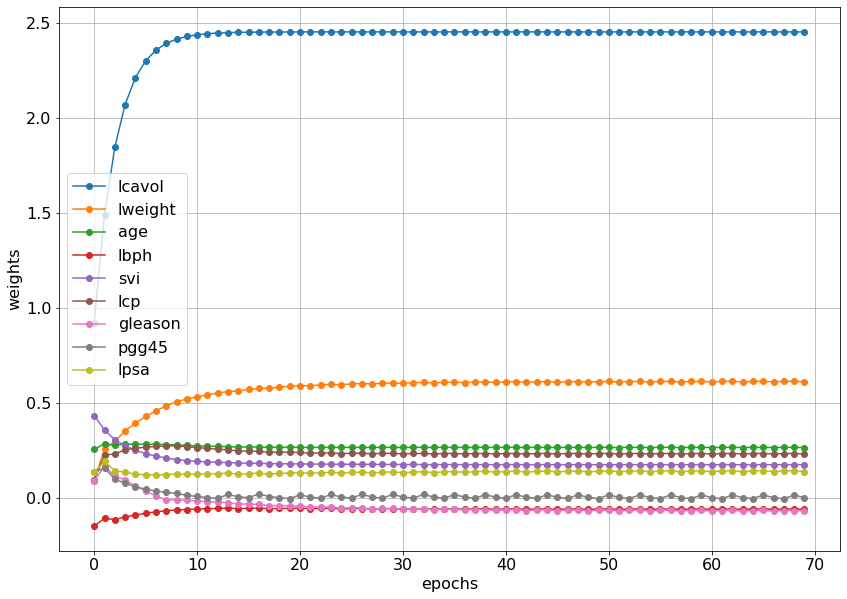

In [17]:
legend_list = cancerData.keys()[1:-1]
plt.rcParams["figure.figsize"] = (14,10)
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}
plt.tick_params(labelsize=16)
plt.grid()
plt.rc('font', **font)
for ii in range(9):
    plt.plot(weight_array[:,ii], label = legend_list[ii], marker= 'o') 
plt.xlabel('epochs')
plt.ylabel('weights')
plt.legend()
plt.savefig('lasso_WEIGHT.png')
plt.show()


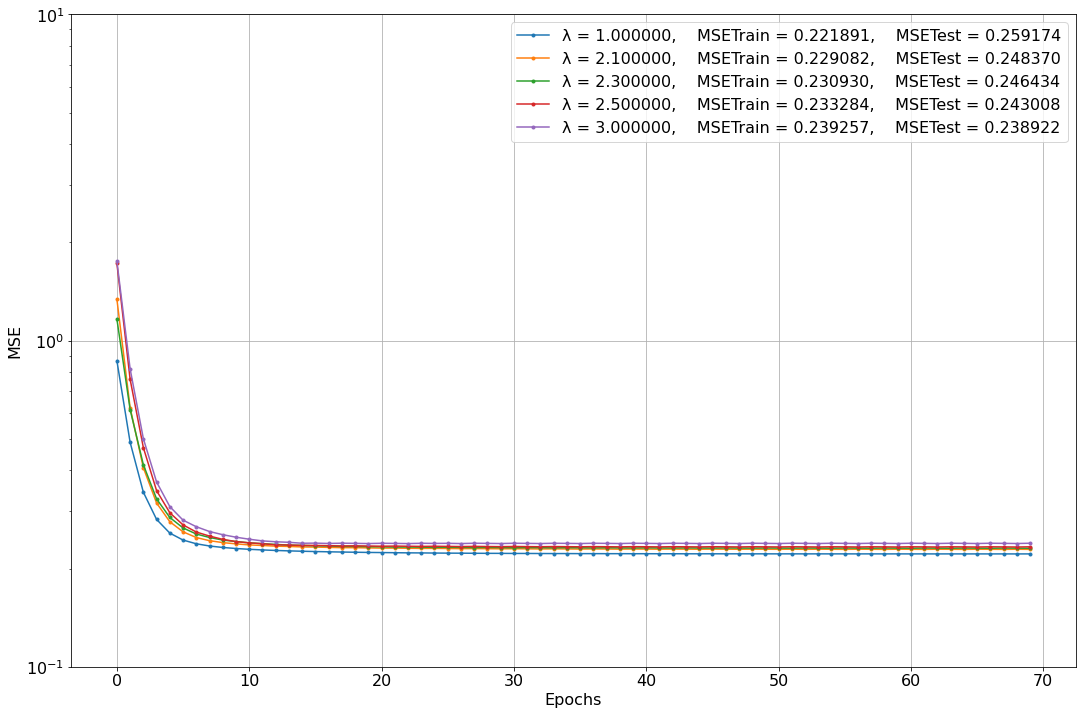

In [18]:
r = np.linspace(0.1,10,10)
r = [1,2.1, 2.3, 2.5,3]
plt.rcParams["figure.figsize"] = (18,12)
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}
plt.tick_params(labelsize=16)
plt.grid()
for i in range(len(r)):
    Wlasso, mean_squared_error,weight_array = GradDesc(x_train_scaled,y_train,0.37,70,r[i])
    MSEtest = MSE(x_test_scaled,y_test,Wlasso)
    plt.semilogy(mean_squared_error,label = 'λ = %f,    MSETrain = %f,    MSETest = %f'%(r[i],mean_squared_error[-1],MSEtest),marker='.')
    plt.ylim([.1,10])
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.savefig('MSE_lasso_COMBINED_lambda.png')
plt.show()
    

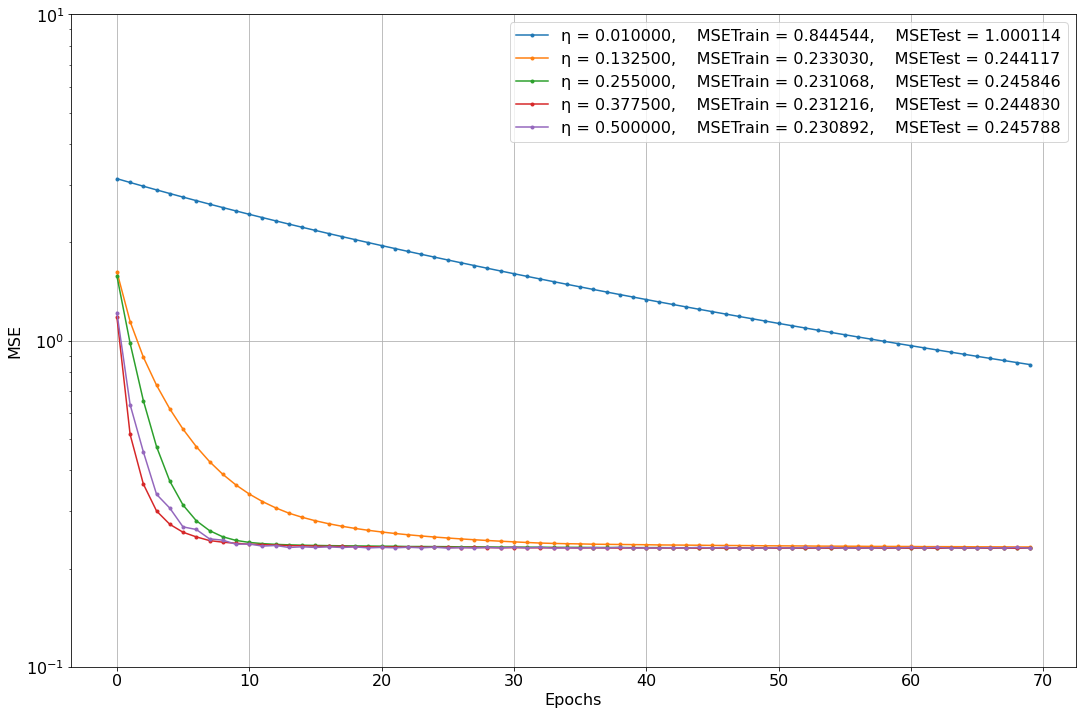

In [19]:
#r = np.linspace(1,100,10)
lr = np.linspace(0.01,0.5,5)
plt.rcParams["figure.figsize"] = (18,12)
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}
plt.tick_params(labelsize=16)
plt.grid()
for i in range(len(lr)):
    Wridge, mean_squared_error,weight_array = GradDesc(x_train_scaled,y_train,lr[i],70,2.3)
    MSEtest = MSE(x_test_scaled,y_test,Wridge)
    plt.semilogy(mean_squared_error,label = 'η = %f,    MSETrain = %f,    MSETest = %f'%(lr[i],mean_squared_error[-1],MSEtest),marker='.')
    plt.ylim([.1,10])
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.savefig('MSE_lasso_COMBINED_lr.png')
plt.show()
    